# Introduction to Pandas 2 | Narrow versus Wide and more

-------


> This is an aggregated tutorial relying on material for the following fantastic sources:
-  [Justin Bois](http://justinbois.github.io/bootcamp/2020/index.html). It contains modified training datasets and adopts content to Colab environment.
- [BIOS821 course at Duke](https://people.duke.edu/~ccc14/bios-821-2017/index.html)
- [Pandas documentation](https://pandas.pydata.org/docs/user_guide/index.html/) 

In [2]:
import numpy as np
import pandas as pd

<hr>

In the last lesson, we learned about Pandas and dipped our toe in to see its power. In this lesson, we will continue to harness the power of Pandas to pull out subsets of data we are interested in.

## Tidy data

[Hadley Wickham](https://en.wikipedia.org/wiki/Hadley_Wickham) wrote a [great article](http://dx.doi.org/10.18637/jss.v059.i10) in favor of "tidy data." Tidy data frames follow the rules:

1. Each variable is a column.
2. Each observation is a row.
3. Each type of observation has its own separate data frame.

This is less pretty to visualize as a table, but we rarely look at data in tables. Indeed, the representation of data which is convenient for visualization is different from that which is convenient for analysis. A tidy data frame is almost always **much** easier to work with than non-tidy formats.

Also, let's take a look at this [article](https://dtkaplan.github.io/DataComputingEbook/chap-tidy-data.html#chap:tidy-data). 

## The data set

The dataset we will be using is a list of all SARS-CoV-2 datasets in [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra) as of January 20, 2021.  

It is obtained by going to https://www.ncbi.nlm.nih.gov/sra and performing a query with the following search terms: `txid2697049[Organism:noexp]`.

Results are downloaded using `Send to:` menu selecting `File` and then `RunInfo`. Let's get these results into this notebook:

In [54]:
df = pd.read_csv('https://github.com/nekrut/BMMB554/raw/master/2021/data/sra_ncov_bmmb554.csv.gz')
df = df[df['size_MB']> 0].reset_index(drop=True)

# Take a look
df

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
0,SRR13486937,2021-01-19 21:07:40,180,SRX9899501,RNA-Seq,cDNA,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,SRP266465,PRJNA622837
1,SRR13486936,2021-01-19 21:06:25,225,SRX9899502,RNA-Seq,cDNA,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,SRP266465,PRJNA622837
2,SRR13486877,2021-01-19 21:06:25,260,SRX9899561,RNA-Seq,cDNA,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,SRP266465,PRJNA622837
3,SRR13486876,2021-01-19 21:06:25,194,SRX9899562,RNA-Seq,cDNA,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,SRP266465,PRJNA622837
4,SRR13486943,2021-01-19 21:07:40,140,SRX9899495,RNA-Seq,cDNA,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,SRP266465,PRJNA622837
...,...,...,...,...,...,...,...,...,...,...,...,...
181677,SRR11140748,2020-02-21 13:46:13,88,SRX7777162,WGS,RANDOM PCR,METAGENOMIC,PAIRED,ILLUMINA,Illumina MiSeq,SRP250294,PRJNA607948
181678,SRR11140747,2020-02-21 13:51:16,316,SRX7777163,WGS,RANDOM PCR,METAGENOMIC,SINGLE,OXFORD_NANOPORE,GridION,SRP250294,PRJNA607948
181679,SRR11140746,2020-02-21 13:42:13,74,SRX7777164,WGS,RANDOM PCR,METAGENOMIC,PAIRED,ILLUMINA,Illumina MiSeq,SRP250294,PRJNA607948
181680,SRR11140745,2020-02-21 13:45:13,229,SRX7777165,WGS,RANDOM PCR,METAGENOMIC,SINGLE,OXFORD_NANOPORE,GridION,SRP250294,PRJNA607948


This data set is in tidy format. Each row represents a single SRA dataset. The properties of each run are given in each column. We already saw the power of having the data in this format when we did Boolean indexing in the last lesson. 

## Finding unique values and counts

How many unique sequencing platforms do we have?



In [41]:
df['Platform'].unique()

array(['ILLUMINA', 'OXFORD_NANOPORE', 'ION_TORRENT', 'PACBIO_SMRT',
       'BGISEQ'], dtype=object)

In [42]:
df['Platform'].value_counts()

ILLUMINA           155937
OXFORD_NANOPORE     25202
ION_TORRENT           507
BGISEQ                 22
PACBIO_SMRT            14
Name: Platform, dtype: int64

## Sorting

(and axes!)

Let's start by sorting on index:

In [45]:
df_subset = df.sample(n=10)

In [46]:
df_subset

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
164110,ERR4246974,2020-06-17 19:27:36,3,ERX4204827,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,Illumina MiSeq,ERP121228,PRJEB37886
161459,SRR12077231,2020-06-23 19:39:16,22,SRX8604518,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,SRP253926,PRJNA614995
126909,ERR4584102,2020-09-12 12:12:30,173,ERX4518127,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
163712,ERR4247507,2020-06-17 19:27:41,18,ERX4205357,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,NextSeq 500,ERP121228,PRJEB37886
109534,SRR12751542,2020-10-01 03:16:33,76,SRX9223695,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,NextSeq 550,SRP253798,PRJNA613958
67732,ERR4793653,2020-11-09 17:55:37,91,ERX4663430,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
99343,ERR4653422,2020-10-03 16:03:34,110,ERX4577166,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
37412,ERR4891702,2020-12-01 17:58:09,23,ERX4759503,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
148234,ERR4393637,2020-08-01 23:49:52,105,ERX4337449,WGA,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,ERP120836,PRJEB37513
178681,ERR4082559,2020-04-30 12:16:54,120,ERX4078740,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886


In [50]:
df_subset.sort_index()

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
37412,ERR4891702,2020-12-01 17:58:09,23,ERX4759503,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
67732,ERR4793653,2020-11-09 17:55:37,91,ERX4663430,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
99343,ERR4653422,2020-10-03 16:03:34,110,ERX4577166,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
109534,SRR12751542,2020-10-01 03:16:33,76,SRX9223695,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,NextSeq 550,SRP253798,PRJNA613958
126909,ERR4584102,2020-09-12 12:12:30,173,ERX4518127,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
148234,ERR4393637,2020-08-01 23:49:52,105,ERX4337449,WGA,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,ERP120836,PRJEB37513
161459,SRR12077231,2020-06-23 19:39:16,22,SRX8604518,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,SRP253926,PRJNA614995
163712,ERR4247507,2020-06-17 19:27:41,18,ERX4205357,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,NextSeq 500,ERP121228,PRJEB37886
164110,ERR4246974,2020-06-17 19:27:36,3,ERX4204827,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,Illumina MiSeq,ERP121228,PRJEB37886
178681,ERR4082559,2020-04-30 12:16:54,120,ERX4078740,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886


In [49]:
df_subset.sort_index(axis = 1)

,BioProject,Experiment,LibraryLayout,LibrarySelection,LibrarySource,LibraryStrategy,Model,Platform,ReleaseDate,Run,SRAStudy,size_MB
164110,PRJEB37886,ERX4204827,SINGLE,PCR,VIRAL RNA,AMPLICON,Illumina MiSeq,ILLUMINA,2020-06-17 19:27:36,ERR4246974,ERP121228,3
161459,PRJNA614995,SRX8604518,PAIRED,PCR,VIRAL RNA,AMPLICON,Illumina MiSeq,ILLUMINA,2020-06-23 19:39:16,SRR12077231,SRP253926,22
126909,PRJEB37886,ERX4518127,PAIRED,PCR,VIRAL RNA,AMPLICON,Illumina NovaSeq 6000,ILLUMINA,2020-09-12 12:12:30,ERR4584102,ERP121228,173
163712,PRJEB37886,ERX4205357,SINGLE,PCR,VIRAL RNA,AMPLICON,NextSeq 500,ILLUMINA,2020-06-17 19:27:41,ERR4247507,ERP121228,18
109534,PRJNA613958,SRX9223695,PAIRED,PCR,VIRAL RNA,AMPLICON,NextSeq 550,ILLUMINA,2020-10-01 03:16:33,SRR12751542,SRP253798,76
67732,PRJEB37886,ERX4663430,PAIRED,PCR,VIRAL RNA,AMPLICON,Illumina NovaSeq 6000,ILLUMINA,2020-11-09 17:55:37,ERR4793653,ERP121228,91
99343,PRJEB37886,ERX4577166,PAIRED,PCR,VIRAL RNA,AMPLICON,Illumina NovaSeq 6000,ILLUMINA,2020-10-03 16:03:34,ERR4653422,ERP121228,110
37412,PRJEB37886,ERX4759503,SINGLE,PCR,VIRAL RNA,AMPLICON,GridION,OXFORD_NANOPORE,2020-12-01 17:58:09,ERR4891702,ERP121228,23
148234,PRJEB37513,ERX4337449,PAIRED,PCR,VIRAL RNA,WGA,Illumina MiSeq,ILLUMINA,2020-08-01 23:49:52,ERR4393637,ERP120836,105
178681,PRJEB37886,ERX4078740,SINGLE,PCR,VIRAL RNA,AMPLICON,GridION,OXFORD_NANOPORE,2020-04-30 12:16:54,ERR4082559,ERP121228,120


Now let's try sorting by values:

In [51]:
df_subset.sort_values(by=['LibraryLayout'])

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
161459,SRR12077231,2020-06-23 19:39:16,22,SRX8604518,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,SRP253926,PRJNA614995
126909,ERR4584102,2020-09-12 12:12:30,173,ERX4518127,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
109534,SRR12751542,2020-10-01 03:16:33,76,SRX9223695,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,NextSeq 550,SRP253798,PRJNA613958
67732,ERR4793653,2020-11-09 17:55:37,91,ERX4663430,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
99343,ERR4653422,2020-10-03 16:03:34,110,ERX4577166,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
148234,ERR4393637,2020-08-01 23:49:52,105,ERX4337449,WGA,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,ERP120836,PRJEB37513
164110,ERR4246974,2020-06-17 19:27:36,3,ERX4204827,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,Illumina MiSeq,ERP121228,PRJEB37886
163712,ERR4247507,2020-06-17 19:27:41,18,ERX4205357,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,NextSeq 500,ERP121228,PRJEB37886
37412,ERR4891702,2020-12-01 17:58:09,23,ERX4759503,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
178681,ERR4082559,2020-04-30 12:16:54,120,ERX4078740,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886


In [52]:
df_subset.sort_values(by=['LibraryLayout','size_MB'])

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
161459,SRR12077231,2020-06-23 19:39:16,22,SRX8604518,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,SRP253926,PRJNA614995
109534,SRR12751542,2020-10-01 03:16:33,76,SRX9223695,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,NextSeq 550,SRP253798,PRJNA613958
67732,ERR4793653,2020-11-09 17:55:37,91,ERX4663430,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
148234,ERR4393637,2020-08-01 23:49:52,105,ERX4337449,WGA,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,ERP120836,PRJEB37513
99343,ERR4653422,2020-10-03 16:03:34,110,ERX4577166,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
126909,ERR4584102,2020-09-12 12:12:30,173,ERX4518127,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
164110,ERR4246974,2020-06-17 19:27:36,3,ERX4204827,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,Illumina MiSeq,ERP121228,PRJEB37886
163712,ERR4247507,2020-06-17 19:27:41,18,ERX4205357,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,NextSeq 500,ERP121228,PRJEB37886
37412,ERR4891702,2020-12-01 17:58:09,23,ERX4759503,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
178681,ERR4082559,2020-04-30 12:16:54,120,ERX4078740,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886


In [53]:
df_subset.sort_values(by=['LibraryLayout','size_MB'],ascending=[True,False])

,Run,ReleaseDate,size_MB,Experiment,LibraryStrategy,LibrarySelection,LibrarySource,LibraryLayout,Platform,Model,SRAStudy,BioProject
126909,ERR4584102,2020-09-12 12:12:30,173,ERX4518127,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
99343,ERR4653422,2020-10-03 16:03:34,110,ERX4577166,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
148234,ERR4393637,2020-08-01 23:49:52,105,ERX4337449,WGA,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,ERP120836,PRJEB37513
67732,ERR4793653,2020-11-09 17:55:37,91,ERX4663430,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina NovaSeq 6000,ERP121228,PRJEB37886
109534,SRR12751542,2020-10-01 03:16:33,76,SRX9223695,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,NextSeq 550,SRP253798,PRJNA613958
161459,SRR12077231,2020-06-23 19:39:16,22,SRX8604518,AMPLICON,PCR,VIRAL RNA,PAIRED,ILLUMINA,Illumina MiSeq,SRP253926,PRJNA614995
178681,ERR4082559,2020-04-30 12:16:54,120,ERX4078740,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
37412,ERR4891702,2020-12-01 17:58:09,23,ERX4759503,AMPLICON,PCR,VIRAL RNA,SINGLE,OXFORD_NANOPORE,GridION,ERP121228,PRJEB37886
163712,ERR4247507,2020-06-17 19:27:41,18,ERX4205357,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,NextSeq 500,ERP121228,PRJEB37886
164110,ERR4246974,2020-06-17 19:27:36,3,ERX4204827,AMPLICON,PCR,VIRAL RNA,SINGLE,ILLUMINA,Illumina MiSeq,ERP121228,PRJEB37886


## Split-apply-combine

The general idea of "Split-Apply-Combine" is shown  in this figure:

<img src="https://camo.githubusercontent.com/60a1e7e95eaef8f9a99f43335368915eafedda3e/687474703a2f2f7777772e686f66726f652e6e65742f737461743537392f736c696465732f73706c69742d6170706c792d636f6d62696e652e706e67" alt="Drawing" style="width: 400px;"/>

> Image from [BIOS703](https://people.duke.edu/~ccc14/bios-821-2017/index.html#)

Let's say we want to compute the total size of SRA runs for each `BioProject`. Ignoring for the second the mechanics of how we would do this with Pandas, let's think about it in English. What do we need to do?

1. **Split** the data set up according to the `'BioProject'` field, i.e., split it up so we have a separate data set for each BioProject ID. .
2. **Apply** a median function to the activity in these split data sets.
3. **Combine** the results of these averages on the split data set into a new, summary data set that contains classes for each platform and medians for each.

We see that the strategy we want is a **split-apply-combine** strategy. This idea was put forward by Hadley Wickham in [this paper](http://dx.doi.org/10.18637/jss.v040.i01). It turns out that this is a strategy we want to use *very* often. Split the data in terms of some criterion. Apply some function to the split-up data. Combine the results into a new data frame.

Note that if the data are tidy, this procedure makes a lot of sense. Choose the column you want to use to split by. All rows with like entries in the splitting column are then grouped into a new data set. You can then apply any function you want into these new data sets. You can then combine the results into a new data frame.

Pandas's split-apply-combine operations are achieved using the `groupby()` method. You can think of `groupby()` as the splitting part. You can then apply functions to the resulting `DataFrameGroupBy` object. The [Pandas documentation on split-apply-combine](http://pandas.pydata.org/pandas-docs/stable/groupby.html) is excellent and worth reading through. It is extensive though, so don't let yourself get intimidated by it.

### Aggregation

Let's go ahead and do our first split-apply-combine on this tidy data set. First, we will split the data set up by `BioProject`.

In [4]:
grouped = df.groupby(['BioProject'])

# Take a look
grouped

There is not much to see in the `DataFrameGroupBy` object that resulted. But there is a lot we can do with this object. Typing `grouped.` and hitting tab will show you the many possibilities. For most of these possibilities, the apply and combine steps happen together and a new data frame is returned. The `grouped.sum()` method is exactly what we want.

In [5]:
df_sum = grouped.sum()

# Take a look
df_sum

,size_MB
BioProject,
PRJEB37513,19806
PRJEB37886,9235309
PRJEB37966,92058
PRJEB38101,533
PRJEB38351,571
...,...
PRJNA691537,85
PRJNA691556,15748
PRJNA692472,215


In [38]:
df_sum = pd.DataFrame(grouped['size_MB'].sum())
df_sum

,size_MB
BioProject,
PRJEB37513,19806
PRJEB37886,9235309
PRJEB37966,92058
PRJEB38101,533
PRJEB38351,571
...,...
PRJNA691537,85
PRJNA691556,15748
PRJNA692472,215


The outputted data frame has the sums of numerical columns only, which we have only one: `size_MS`. Note that this data frame has `Platform` as the name of the row index. If we want to instead keep `Platform` (which, remember, is what we used to split up the data set before we computed the summary statistics) as a column, we can use the `reset_index()` method.

In [6]:
df_sum.reset_index()

,BioProject,size_MB
0,PRJEB37513,19806
1,PRJEB37886,9235309
2,PRJEB37966,92058
3,PRJEB38101,533
4,PRJEB38351,571
...,...,...
184,PRJNA691537,85
185,PRJNA691556,15748
186,PRJNA692472,215
187,PRJNA692481,173


Note, though, that this was not done in-place. If you want to update your data frame, you have to explicitly do so.

In [7]:
df_sum = df_sum.reset_index()

We can also use multiple columns in our `groupby()` operation. To do this, we simply pass in a list of columns into `df.groupby()`. We will **chain the methods**, performing a groupby, applying a median, and then resetting the index of the result, all in one line.

In [8]:
df.groupby(['BioProject', 'Platform']).sum().reset_index()

,BioProject,Platform,size_MB
0,PRJEB37513,ILLUMINA,19806
1,PRJEB37886,ILLUMINA,7640033
2,PRJEB37886,OXFORD_NANOPORE,1595276
3,PRJEB37966,OXFORD_NANOPORE,92058
4,PRJEB38101,ILLUMINA,533
...,...,...,...
207,PRJNA691556,ILLUMINA,10497
208,PRJNA691556,OXFORD_NANOPORE,5251
209,PRJNA692472,ILLUMINA,215
210,PRJNA692481,ION_TORRENT,173


This type of operation is called an **aggregation**. That is, we split the data set up into groups, and then computed a summary statistic for each group, in this case the median. 

You now have tremendous power in your hands. When your data are tidy, you can rapidly accelerate the ubiquitous split-apply-combine methods. Importantly, you now have a logical framework to think about how you slice and dice your data. As a final, simple example, I will show you how to go start to finish after loading the data set into a data frame, splitting by `BioProject` and `Platform`, and then getting the quartiles and extrema, in addition to the mean and standard deviation.

In [11]:
df.groupby(['BioProject', 'Platform'])['size_MB'].describe()

count        mean         std    min     25%  \
BioProject  Platform                                                           
PRJEB37513  ILLUMINA            244.0   81.172131   35.651535   21.0   36.00   
PRJEB37886  ILLUMINA         114178.0   66.913355   67.270998    1.0   22.00   
            OXFORD_NANOPORE   19128.0   83.400042  115.955997    1.0   19.00   
PRJEB37966  OXFORD_NANOPORE     752.0  122.417553  168.301885    5.0   67.00   
PRJEB38101  ILLUMINA              6.0   88.833333   75.058422    4.0   25.00   
...                               ...         ...         ...    ...     ...   
PRJNA691556 ILLUMINA            120.0   87.475000   42.484987   25.0   60.75   
            OXFORD_NANOPORE      90.0   58.344444   37.487424    2.0   32.25   
PRJNA692472 ILLUMINA             47.0    4.574468    0.650908    2.0    4.00   
PRJNA692481 ION_TORRENT           1.0  173.000000         NaN  173.0  173.00   
PRJNA692653 ILLUMINA             10.0   70.400000  101.956636    1.0    3.50   

                               50%     75%     max  
BioProject  Platform                                
PRJEB37513  ILLUMINA          92.5  108.00   161.0  
PRJEB37886  ILLUMINA          59.0   89.00  3536.0  
            OXFORD_NANOPORE   51.0  108.00  3845.0  
PRJEB37966  OXFORD_NANOPORE  110.0  150.00  2846.0  
PRJEB38101  ILLUMINA          89.0  147.00   181.0  
...                            ...     ...     ...  
PRJNA691556 ILLUMINA          75.0  104.25   245.0  
            OXFORD_NANOPORE   51.0   77.75   181.0  
PRJNA692472 ILLUMINA           5.0    5.00     5.0  
PRJNA692481 ION_TORRENT      173.0  173.00   173.0  
PRJNA692653 ILLUMINA           8.5  135.50   275.0  

[212 rows x 8 columns]

In [12]:
df.groupby(['BioProject', 'Platform'])['size_MB'].describe().reset_index()

,BioProject,Platform,count,mean,std,min,25%,50%,75%,max
0,PRJEB37513,ILLUMINA,244.0,81.172131,35.651535,21.0,36.00,92.5,108.00,161.0
1,PRJEB37886,ILLUMINA,114178.0,66.913355,67.270998,1.0,22.00,59.0,89.00,3536.0
2,PRJEB37886,OXFORD_NANOPORE,19128.0,83.400042,115.955997,1.0,19.00,51.0,108.00,3845.0
3,PRJEB37966,OXFORD_NANOPORE,752.0,122.417553,168.301885,5.0,67.00,110.0,150.00,2846.0
4,PRJEB38101,ILLUMINA,6.0,88.833333,75.058422,4.0,25.00,89.0,147.00,181.0
...,...,...,...,...,...,...,...,...,...,...
207,PRJNA691556,ILLUMINA,120.0,87.475000,42.484987,25.0,60.75,75.0,104.25,245.0
208,PRJNA691556,OXFORD_NANOPORE,90.0,58.344444,37.487424,2.0,32.25,51.0,77.75,181.0
209,PRJNA692472,ILLUMINA,47.0,4.574468,0.650908,2.0,4.00,5.0,5.00,5.0
210,PRJNA692481,ION_TORRENT,1.0,173.000000,NaN,173.0,173.00,173.0,173.00,173.0


Yes, that's right. One single, clean, easy to read line of code. In coming tutorials, we will see how to use tidy data to quickly generate plots.

## Tidying a data set

You should always organize your data sets in a tidy format. However, this is sometimes just not possible, since you data sets can come from instruments that do not output the data in tidy format (though most do, at least in my experience), and you often have collaborators that send data in untidy formats.

The most useful function for tidying data is `pd.melt()`. To demonstrate this we will use a dataset describing read coverage across SARS-CoV-2 genomes for a number of samples.

In [56]:
df = pd.read_csv('https://github.com/nekrut/BMMB554/raw/master/2021/data/coverage.tsv',sep='\t')

df.head()

,#chr,start,end,SRR12733539.bam,SRR12733570.bam,SRR12733581.bam,SRR12733607.bam,SRR12733616.bam,SRR12733619.bam
0,NC_045512.2,0,100,259.0,3490.0,1645.0,399.0,598.0,107.0
1,NC_045512.2,100,200,720.0,9106.0,3780.0,1063.0,1404.0,272.0
2,NC_045512.2,200,300,979.0,14207.0,5054.0,1450.0,1921.0,344.0
3,NC_045512.2,300,400,983.0,15438.0,5212.0,1396.0,1908.0,328.0
4,NC_045512.2,400,500,1297.0,17257.0,6174.0,1567.0,2021.0,385.0


Clearly these data are not tidy. When we melt the data frame, the data within it, called **values**, become a single column. The headers, called **variables**, also become new columns. So, to melt it, we need to specify what we want to call the values and what we want to call the variable. [`pd.melt()`](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) does the rest!

![](https://pandas.pydata.org/docs/_images/07_melt.svg)

> Image from [Pandas Docs](https://pandas.pydata.org/docs/getting_started/intro_tutorials/07_reshape_table_layout.html#wide-to-long-format).



In [57]:
melted = pd.melt(df, value_name='coverage', var_name=['sample'],value_vars=df.columns[3:],id_vars=['start','end'])

melted.head()

,start,end,sample,coverage
0,0,100,SRR12733539.bam,259.0
1,100,200,SRR12733539.bam,720.0
2,200,300,SRR12733539.bam,979.0
3,300,400,SRR12733539.bam,983.0
4,400,500,SRR12733539.bam,1297.0


...and we are good to do with a tidy DataFrame! Let's take a look at the summary. This wouild allow us to easily plot coverage:

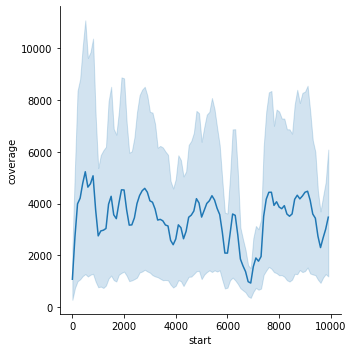

In [58]:
import seaborn as sns
sns.relplot(data=melted, x='start',y='coverage',kind='line')

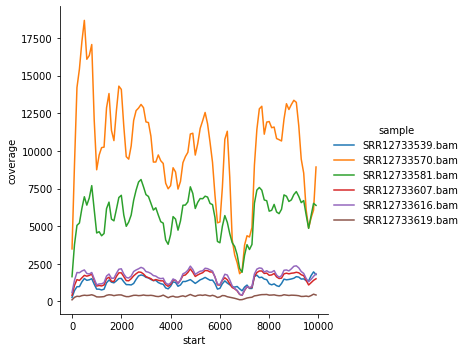

In [59]:
sns.relplot(data=melted, x='start',y='coverage',kind='line',hue='sample')

In [60]:
melted.groupby(['sample']).describe()

start                                                    \
                 count    mean          std  min     25%     50%     75%   
sample                                                                     
SRR12733539.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   
SRR12733570.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   
SRR12733581.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   
SRR12733607.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   
SRR12733616.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   
SRR12733619.bam  100.0  4950.0  2901.149198  0.0  2475.0  4950.0  7425.0   

                           end          ...                  coverage  \
                    max  count    mean  ...     75%      max    count   
sample                                  ...                             
SRR12733539.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   
SRR12733570.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   
SRR12733581.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   
SRR12733607.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   
SRR12733616.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   
SRR12733619.bam  9900.0  100.0  5050.0  ...  7525.0  10000.0    100.0   

                                                                            \
                     mean          std     min      25%      50%       75%   
sample                                                                       
SRR12733539.bam   1271.75   295.525499   259.0  1093.00   1310.0   1484.25   
SRR12733570.bam  10112.04  3412.618417  1843.0  8582.25  10615.5  12062.75   
SRR12733581.bam   5800.16  1360.497731  1645.0  5038.50   6118.5   6766.50   
SRR12733607.bam   1509.15   389.486359   399.0  1334.50   1571.0   1834.75   
SRR12733616.bam   1691.37   444.477395   414.0  1446.50   1820.0   2030.00   
SRR12733619.bam    359.54    77.393318   107.0   321.50    384.5    411.00   

                          
                     max  
sample                    
SRR12733539.bam   1963.0  
SRR12733570.bam  18673.0  
SRR12733581.bam   8100.0  
SRR12733607.bam   2159.0  
SRR12733616.bam   2366.0  
SRR12733619.bam    482.0  

[6 rows x 24 columns]

In [61]:
melted.groupby(['sample'])['coverage'].describe()

,count,mean,std,min,25%,50%,75%,max
sample,,,,,,,,
SRR12733539.bam,100.0,1271.75,295.525499,259.0,1093.00,1310.0,1484.25,1963.0
SRR12733570.bam,100.0,10112.04,3412.618417,1843.0,8582.25,10615.5,12062.75,18673.0
SRR12733581.bam,100.0,5800.16,1360.497731,1645.0,5038.50,6118.5,6766.50,8100.0
SRR12733607.bam,100.0,1509.15,389.486359,399.0,1334.50,1571.0,1834.75,2159.0
SRR12733616.bam,100.0,1691.37,444.477395,414.0,1446.50,1820.0,2030.00,2366.0
SRR12733619.bam,100.0,359.54,77.393318,107.0,321.50,384.5,411.00,482.0


To get back from melted (narrow) format to wide format we can use [`pivot()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html#pandas.DataFrame.pivot) function. 

![](https://pandas.pydata.org/docs/_images/07_pivot.svg)

> Image from [Pandas Docs](https://pandas.pydata.org/docs/getting_started/intro_tutorials/07_reshape_table_layout.html#long-to-wide-table-format).





In [69]:
melted.pivot(index=['start','end'],columns='sample',values='coverage')

,sample,SRR12733539.bam,SRR12733570.bam,SRR12733581.bam,SRR12733607.bam,SRR12733616.bam,SRR12733619.bam
start,end,,,,,,
0,100,259.0,3490.0,1645.0,399.0,598.0,107.0
100,200,720.0,9106.0,3780.0,1063.0,1404.0,272.0
200,300,979.0,14207.0,5054.0,1450.0,1921.0,344.0
300,400,983.0,15438.0,5212.0,1396.0,1908.0,328.0
400,500,1297.0,17257.0,6174.0,1567.0,2021.0,385.0
...,...,...,...,...,...,...,...
9500,9600,1378.0,6077.0,5749.0,1394.0,1523.0,357.0
9600,9700,1373.0,4875.0,4856.0,1094.0,1309.0,322.0
9700,9800,1717.0,5549.0,5698.0,1246.0,1467.0,389.0


## Working with multiple tables

Working with multiple tables often involves joining them on a common key:

![](https://pandas.pydata.org/docs/_images/08_merge_left.svg)

In fact, this can be done in several different ways described below. But first let's define two simple dataframes:



In [22]:
!pip install --upgrade pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=ddefea0e25e4df3cb72c758e325ea5511e8dae8d656d8e328571933f0bea6b8a
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [23]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [24]:
df1 = pd.DataFrame({"key": ["A", "B", "C", "D"], "value": np.random.randn(4)})
df2 = pd.DataFrame({"key": ["B", "D", "D", "E"], "value": np.random.randn(4)})

In [26]:
df1

,key,value
0,A,-1.270366
1,B,-0.181635
2,C,0.114000
3,D,0.865500


In [27]:
df2

,key,value
0,B,-0.696855
1,D,-0.178705
2,D,-1.189286
3,E,1.381098


### Inner join

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/SQL_Join_-_07_A_Inner_Join_B.svg/234px-SQL_Join_-_07_A_Inner_Join_B.svg.png?20170204165143)

> Figure from Wikimedia Commons

Using pandas `merge`:

In [28]:
pd.merge(df1, df2, on="key")

,key,value_x,value_y
0,B,-0.181635,-0.696855
1,D,0.865500,-0.178705
2,D,0.865500,-1.189286


Using `pysqldf`:

In [29]:
pysqldf('select * from df1 join df2 on df1.key=df2.key')

,key,value,key,value
0,B,-0.181635,B,-0.696855
1,D,0.865500,D,-1.189286
2,D,0.865500,D,-0.178705


### Left join

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/SQL_Join_-_01b_A_Left_Join_B.svg/234px-SQL_Join_-_01b_A_Left_Join_B.svg.png?20170204144906)

> Figure from Wikimedia Commons

Using pandas `merge`:

In [30]:
pd.merge(df1, df2, on="key", how="left").fillna('.')

,key,value_x,value_y
0,A,-1.270366,.
1,B,-0.181635,-0.696855
2,C,0.114000,.
3,D,0.865500,-0.178705
4,D,0.865500,-1.189286


Using `pysqldf`:

In [31]:
pysqldf('select * from df1 left join df2 on df1.key=df2.key').fillna('.')

,key,value,key,value
0,A,-1.270366,.,.
1,B,-0.181635,B,-0.696855
2,C,0.114000,.,.
3,D,0.865500,D,-1.189286
4,D,0.865500,D,-0.178705


In [32]:
pysqldf('select df1.key, df1.value as value_x, df2.value as value_y from df1 left join df2 on df1.key=df2.key').fillna('.')

,key,value_x,value_y
0,A,-1.270366,.
1,B,-0.181635,-0.696855
2,C,0.114000,.
3,D,0.865500,-1.189286
4,D,0.865500,-0.178705


### Right join

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/SQL_Join_-_03_A_Right_Join_B.svg/234px-SQL_Join_-_03_A_Right_Join_B.svg.png?20170130230641)

> Figure from Wikimedia Commons

Using pandas `merge`:

In [33]:
pd.merge(df1, df2, on="key", how="right").fillna('.')

,key,value_x,value_y
0,B,-0.181635,-0.696855
1,D,0.8655,-0.178705
2,D,0.8655,-1.189286
3,E,.,1.381098


### Full join

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/SQL_Join_-_05_A_Full_Join_B.svg/234px-SQL_Join_-_05_A_Full_Join_B.svg.png?20170130230643)

> Figure from Wikimedia Commons

Using pandas `merge`:

In [34]:
pd.merge(df1, df2, on="key", how="outer").fillna('.')

,key,value_x,value_y
0,A,-1.270366,.
1,B,-0.181635,-0.696855
2,C,0.114,.
3,D,0.8655,-0.178705
4,D,0.8655,-1.189286
5,E,.,1.381098


## Computing environment

In [ ]:
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas